<div id="container" style="position:relative;">
<div style="float:left"><h1> Model 2 : Linear Regression Monthly Forecast</h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://twomagpiesbakery.co.uk/wp-content/uploads/2020/11/logo-no-site.jpg" />
</div>
</div>

**Steps to calculate the linear regression model for a monthly revenue forecast.**
 
In order for a successful linear regression model there are a few assumptions about the data that must be made, these are:

- There is a linear relationship between the dependent and independent variables
- The independent variables are independent of each other (no multicollinearity)
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables

If these are not met, revenue forecasts will be less accurate. 

**Accuracy Evaluation** 
- R<sup>2</sup> - a statistical measure of fit that indicates how much variation of a daily revenue is explained by the independent variables in the regression model.
- Root Mean Squared Error (RMSE) - RMSE is a measure of how to spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. This is similar to the MAE score but larger errors are penalised more heavily. 
- Akaike Information Criterion (AIC) - evaluates how well a model fits the data, depending on the number of independent variables used. The best-fit model is the one that explains the greatest amount of variation using the fewest possible independent variables. 
- Mean Absolute Percentage Error (MAPE) value, which is the percentage of the average absolute values of error between the true revenue values and the predicted ones. 

The model with the best evaluation scores will be selected as the optimal linear regression model for the monthly forecast. Full discussion can be found here: [Evalution of the Models](#Evaluation-of-the-Models). 

---

# Contents 

**[EDA and Data Processing](#EDA-and-Data-Processing)**

**[1. Model 1 - Special Days](#Model-1---Special-Days)**
    
      
**[2. Model 2 - Dropping `Closed_Xmas` and `Bank_Holiday` ](#Model-2---Dropping-Closed_Xmas-and-Bank_Holiday)**

**[3. Model 3 - Dropping `Weekday`](#Model-3---Dropping-Weekday)**

**[4. Model 4 - Adding New Feautres](#Model-4---Adding-New-Features)**

**[5. Model 5 - Dropping `Closed_Xmas`, `Weekday` and `Bank_Holiday`](#Model-5---Dropping-Closed_Xmas-,-Weekday-and-Bank_Holiday)**

   - [Performing VIF to Reduce Features](#Performing-VIF-to-Reduce-Features)


**[6. Model 6 - Dropping `3M_MA_lag`](#Model-6---Dropping-3M_MA_lag)**

**[Evaluation of the Models](#Evaluation-of-the-Models)**
    
**[Summary](#Summary)**

**[Next Steps](#Next-Steps)**
___

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objs as go
import statsmodels.api as sm
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.tseries.offsets import DateOffset

## Importing Custom Functions

In [2]:
import BakeryFunctions as bakery

## To Get Current Directory

In [3]:
working_directory = os.getcwd()
working_directory

'/Users/abimagnall/Documents/BrainStation/Capstone/Data'

## Importing Processed Datasets

In [4]:
# Importing the dataset
total_rev = pd.read_csv(working_directory+'/5_timeseries_data/total_revenue_encoded.csv', index_col=0)

# Converting the index to a datetime index 
total_rev.index = pd.to_datetime(total_rev.index)

# To validate it imported correctly 
display(total_rev.head())

,Total_Revenue,TAVG,PRCP,CPI_Electricity,CPI_Food,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend
2020-09-01,9780.76,24.0,0.00,107.6,102.8,0,0,0,1,0
2020-09-02,10037.55,27.0,0.00,107.6,102.8,0,0,0,1,0
2020-09-03,9419.30,31.0,0.07,107.6,102.8,0,0,0,1,0
2020-09-04,10606.15,27.0,0.08,107.6,102.8,0,0,0,1,0
2020-09-05,12922.00,23.0,0.01,107.6,102.8,0,0,0,0,1


# EDA and Data Processing
For the monthly forecast the following steps have to be taken: 
- Weather and CPI data is dropped as it is not suitable for forecasting 6 weeks ahead 
- Data is resampled to weekly and `Total_Revenue`, `Special Days` are summed 

In [5]:
total_rev_monthly = total_rev.drop(columns=['TAVG', 'PRCP', 'CPI_Electricity','CPI_Food']).copy()

In [6]:
# the 'W' option specifies Weekly frequency
total_rev_monthly = total_rev_monthly.resample('MS').sum().round(2)
display(total_rev_monthly.tail(10))

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend
2021-12-01,285428.48,2,1,12,12,4
2022-01-01,265070.84,1,0,3,19,8
2022-02-01,248737.03,0,0,16,10,2
2022-03-01,266550.35,0,0,0,23,8
2022-04-01,365684.13,2,0,14,11,3
2022-05-01,332789.82,1,0,4,19,7
2022-06-01,351262.48,2,0,3,19,6
2022-07-01,422977.42,0,0,9,16,6
2022-08-01,496394.56,2,0,29,0,0
2022-09-01,350491.42,0,0,4,20,6


## Exploration into Multicolinearity
Similar with the daily and weekly revenue forecast, multicolinearity needs to be determined and accounted for if present. To do this a heatmap of the correlation values is plotted. 

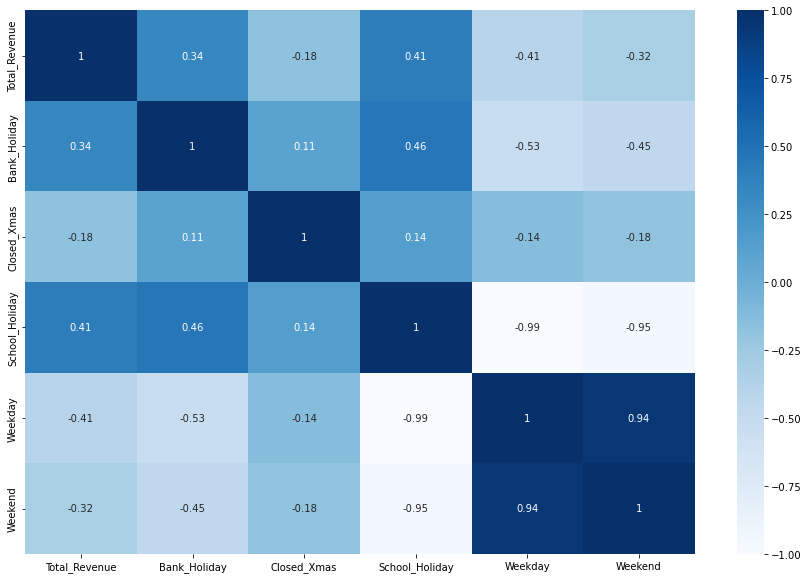

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(total_rev_monthly.corr(), annot=True, vmin=-1, vmax=1,cmap='Blues')
plt.show()

## Observations
It can be seen that `Weekday` and `Weekend`, `Weekday` and `School_Holiday` and `School_Holiday` and `Weekend` have extremely high correlations with each other. 

However, for the purposes of the monthly forecasting, as there is less data to train the model, all the features will be kept in the initial model and have the p-value evaluated to determine if they statistically significant or not. 

## Splitting the Train and Test Data

In [109]:
linear_processed = total_rev_monthly.copy()

In [52]:
# Splitting the train and test data
train = linear_processed.loc[linear_processed.index <= '2022-03-01'].dropna().copy()
test = linear_processed.loc[linear_processed.index > '2022-03-01'].copy()

In [53]:
# The total revenue and moving average columns are dropped from the independent variables list 
independent_variables = train.drop(columns=['Total_Revenue']).copy()

# Model 1 - Special Days
For the first model, only the special days will be evaluated as the baseline model. By adding additional features of a moving average, this reduces the dataset size and therefore the likelihood of the model accurately predicting the monthly revenue. 

In [60]:
# First an empty results dataframe is created to track the accuracy of the models run
model_scores = pd.DataFrame()

In [61]:
y = train['Total_Revenue']

# First the X and y values need to splitted: 
X = independent_variables

# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)

# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)

# The model is fitted using the .fit() method
lm_revenue_results = lm_revenue.fit()

# The results are displayed using the .summary() method
lm_revenue_results.summary()

/Users/abimagnall/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     2.930
Date:                Tue, 25 Oct 2022   Prob (F-statistic):              0.112
Time:                        23:48:43   Log-Likelihood:                -142.28
No. Observations:                  12   AIC:                             296.6
Df Residuals:                       6   BIC:                             299.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.078e+06   7.31e+05     -1.475      0.191   -2.87e+06    7.11e+05
Bank_Holiday    8465.6747   2.48e+04      0.342      0.744   -5.21e+04    6.91e+04
Closed_Xmas     1.264e+04   5.78e+04      0.218      0.834   -1.29e+05    1.54e+05
School_Holiday  5.179e+04   2.46e+04      2.107      0.080   -8363.640    1.12e+05
Weekday         4.003e+04   2.91e+04      1.377      0.218   -3.11e+04    1.11e+05
Weekend         5.806e+04    1.9e+04      3.049      0.023    1.15e+04    1.05e+05
==============================================================================
Omnibus:                        2.322   Durbin-Watson:                   1.609
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                0.934
Skew:                           0.011   Prob(JB):                        0.627
Kurtosis:                       1.634   Cond. No.                         989.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
X_test = test.drop(columns=['Total_Revenue']).copy()
X_test_withconstant = sm.add_constant(X_test)

In [66]:
# Predictions
prediction_1 = lm_revenue_results.predict(X_test_withconstant)

In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, 
                         y=train['Total_Revenue'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Total_Revenue'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=prediction_1, mode='lines', name='Prediction 1'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Total Revenue (£)', 
    xaxis_title='Date',
    title='Model 1 - Linear Regression Predicted Monthly Revenue'
)
fig.show()

In [68]:
bakery.full_accuracy_report(test['Total_Revenue'],
                            prediction_1, 'monthly forecast')

The RMSE for the monthly forecast is: 82605.27

The MAE between the actual and monthly forecast revenue is 73107.78

The MAPE between the actual and monthly forecast revenue is 19.6%


## Model 1 Evaluation
The initial models achieved accuracies of: 
- R<sup>2</sup> value of 0.709
- RMSE of 82605.27
- AIC score of 296.6 - This sets the baseline AIC value for other models to be compared with, better models will have a lower AIC score 
- A MAPE score of 19.6% - which means.. 

Looking at the p-values from the model, all of them are greater than the threshold value of 0.05 except for `Weekend`. Therefore, the next iteration of the model the 2 features with the greatest p-values, `Closed_Xmas` and `Bank_Holiday` will be dropped. 

In [69]:
# To add the scores to the results table 
model_scores = bakery.add_results(model_scores, 1, 0.709, 82605.27, 296.6, '19.6%', 'All special days')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,82605.27,296.6,19.6%,All special days


# Model 2 - Dropping `Closed_Xmas` and `Bank_Holiday` 

In [71]:
http://localhost:8888/notebooks/Documents/BrainStation/Capstone/Data/Model_2_Linear_Regression%20Monthly%20Forecast.ipynb#Model-2---Dropping-Closed-Xmas-and-Bank_Holiday# Splitting the train and test data
train = linear_processed.loc[linear_processed.index <= '2022-03-01'].dropna().copy()
test = linear_processed.loc[linear_processed.index > '2022-03-01'].copy()

In [70]:
# The chosen columns are dropped 
independent_variables_2 = independent_variables.drop(columns=['Bank_Holiday', 'Closed_Xmas']).copy()

In [72]:
y = train['Total_Revenue']

# First the X and y values need to splitted: 
X = independent_variables_2

# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)

# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)

# The model is fitted using the .fit() method
lm_revenue_results = lm_revenue.fit()

# The results are displayed using the .summary() method
lm_revenue_results.summary()

/Users/abimagnall/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     6.225
Date:                Tue, 25 Oct 2022   Prob (F-statistic):             0.0173
Time:                        23:52:16   Log-Likelihood:                -142.47
No. Observations:                  12   AIC:                             292.9
Df Residuals:                       8   BIC:                             294.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.503e+05   4.46e+05     -1.906      0.093   -1.88e+06    1.78e+05
School_Holiday  4.445e+04   1.57e+04      2.826      0.022    8182.425    8.07e+04
Weekday         3.103e+04   1.77e+04      1.750      0.118   -9857.951    7.19e+04
Weekend         5.467e+04   1.53e+04      3.581      0.007    1.95e+04    8.99e+04
==============================================================================
Omnibus:                        4.116   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                1.188
Skew:                          -0.070   Prob(JB):                        0.552
Kurtosis:                       1.465   Cond. No.                         685.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
X_test = test.drop(columns=['Total_Revenue', 'Bank_Holiday', 'Closed_Xmas']).copy()
X_test_withconstant = sm.add_constant(X_test)

In [75]:
# Predictions
prediction_2 = lm_revenue_results.predict(X_test_withconstant)
prediction_2

2022-04-01    277440.303446
2022-05-01    299869.811256
2022-06-01    200745.439444
2022-07-01    374360.059872
2022-08-01    438845.446170
2022-09-01    276230.411858
Freq: MS, dtype: float64

In [76]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, 
                         y=train['Total_Revenue'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Total_Revenue'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=prediction_2, mode='lines', name='Prediction 2'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Total Revenue (£)', 
    xaxis_title='Date',
    title='Model 2 - Linear Regression Predicted Monthly Revenue'
)
fig.show()

In [77]:
bakery.full_accuracy_report(test['Total_Revenue'],
                            prediction_2, 'monthly forecast')

The RMSE for the monthly forecast is: 84376.46

The MAE between the actual and monthly forecast revenue is 75351.39

The MAPE between the actual and monthly forecast revenue is 20.2%


## Model 2 Evaluation
By removing the two features with large p-values this has decreased the R<sup>2</sup> value slightly and increased the MAPE score, suggesting that this model is slightly less accurate and forecasting monthly revenue. 

However, it can be seen from the p-values, that `Weekday` is still greater than 0.05, therefore this will be dropped in the next iteration. 

In [78]:
# To add the scores to the results table 
model_scores = bakery.add_results(model_scores, 2,  0.700, 84376.46, 292.9, '20.2%', 'Dropped Bank hol, closed Xmas')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,82605.27,296.6,19.6%,All special days
1,2,0.700,84376.46,292.9,20.2%,"Dropped Bank hol, closed Xmas"


# Model 3 - Dropping `Weekday`

In [79]:
independent_variables_3 = independent_variables_2.drop(columns=['Weekday']).copy()

In [80]:
y = train['Total_Revenue']

# First the X and y values need to splitted: 
X = independent_variables_3

# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)

# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)

# The model is fitted using the .fit() method
lm_revenue_results = lm_revenue.fit()

# The results are displayed using the .summary() method
lm_revenue_results.summary()

/Users/abimagnall/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     6.351
Date:                Tue, 25 Oct 2022   Prob (F-statistic):             0.0190
Time:                        23:55:27   Log-Likelihood:                -144.41
No. Observations:                  12   AIC:                             294.8
Df Residuals:                       9   BIC:                             296.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.943e+04   1.35e+05     -0.736      0.481   -4.05e+05    2.06e+05
School_Holiday  1.829e+04   5417.688      3.376      0.008    6032.847    3.05e+04
Weekend         4.599e+04    1.6e+04      2.873      0.018    9771.404    8.22e+04
==============================================================================
Omnibus:                        0.983   Durbin-Watson:                   1.184
Prob(Omnibus):                  0.612   Jarque-Bera (JB):                0.736
Skew:                           0.271   Prob(JB):                        0.692
Kurtosis:                       1.915   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
X_test = test.drop(columns=['Total_Revenue', 'Bank_Holiday', 'Closed_Xmas', 'Weekday']).copy()

In [82]:
X_test_withconstant = sm.add_constant(X_test)

In [83]:
# Predictions
prediction_3 = lm_revenue_results.predict(X_test_withconstant)
prediction_3

2022-04-01    294572.031024
2022-05-01    295637.539252
2022-06-01    231361.382478
2022-07-01    341092.433422
2022-08-01    430936.713534
2022-09-01    249649.890968
Freq: MS, dtype: float64

In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, 
                         y=train['Total_Revenue'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Total_Revenue'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=prediction_3, mode='lines', name='Prediction 3'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Total Revenue (£)', 
    xaxis_title='Date',
    title='Model 3 - Linear Regression Predicted Monthly Revenue'
)
fig.show()

In [86]:
bakery.full_accuracy_report(test['Total_Revenue'],
                            prediction_3, 'Monthly forecast')

The RMSE for the Monthly forecast is: 83638.5

The MAE between the actual and Monthly forecast revenue is 79391.64

The MAPE between the actual and Monthly forecast revenue is 21.0%


## Model 3 Evaluation
By removing `Weekday` all the p-values are less than 0.05, therefore deemed statistically significant. 

However, the R<sup>2</sup> value has decreased dramatically, and the MAPE score increased suggesting that this model is slightly less accurate and forecasting monthly revenue than model 1 or 2. 

In [87]:
# To add the scores to the results table 
model_scores = bakery.add_results(model_scores, 3, 0.585, 83638.5, 294.8, '21.0%', 'Dropped Weekday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,82605.27,296.6,19.6%,All special days
1,2,0.700,84376.46,292.9,20.2%,"Dropped Bank hol, closed Xmas"
2,3,0.585,83638.50,294.8,21.0%,Dropped Weekday


# Model 4 - Adding New Features 
In order to try and improve the model further, the moving average lag values will be calculated for the 3 month moving average, and the variance. The 7 and 12 month moving averages will not be included, despite the 12 month moving average having the lowest MAPE score in the baseline model, as this would cause too many data points to be lost. 

In [110]:
linear_ma = linear_processed.copy()

In [111]:
# The moving average is calculated using the rev_moving_average function 
bakery.rev_moving_average(linear_ma, 3, '3M_MA')

In [112]:
# To move the MA data over
for row in linear_ma.index:
    try:
        linear_ma.loc[row,'3M_MA_lag'] = linear_ma.loc[row-DateOffset(months=6),'3M_MA']

    except:
        continue

In [113]:
# To validate it worked
linear_ma.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend,3M_MA,3M_MA_lag
2020-09-01,271314.93,0,0,0,22,8,NaN,NaN
2020-10-01,267385.25,0,0,8,17,6,NaN,NaN
2020-11-01,143635.13,0,0,0,21,9,NaN,NaN
2020-12-01,173145.73,0,1,12,14,4,227445.10,NaN
2021-01-01,95207.98,1,0,3,19,8,194722.04,NaN


In [114]:
# To calculate the variance between the moving average and the actual revenue 
for row in linear_ma.index:
    linear_ma.loc[row,'3M_Var'] = linear_ma.loc[row,'3M_MA'] - linear_ma.loc[row,'Total_Revenue']

linear_ma.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend,3M_MA,3M_MA_lag,3M_Var
2020-09-01,271314.93,0,0,0,22,8,NaN,NaN,NaN
2020-10-01,267385.25,0,0,8,17,6,NaN,NaN,NaN
2020-11-01,143635.13,0,0,0,21,9,NaN,NaN,NaN
2020-12-01,173145.73,0,1,12,14,4,227445.10,NaN,54299.37
2021-01-01,95207.98,1,0,3,19,8,194722.04,NaN,99514.06


In [115]:
# To move the MA data over
for row in linear_ma.index:
    try:
        linear_ma.loc[row,'3M_Var_lag'] = linear_ma.loc[row-DateOffset(months=6),'3M_Var']
    except:
        continue

In [116]:
linear_ma.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend,3M_MA,3M_MA_lag,3M_Var,3M_Var_lag
2020-09-01,271314.93,0,0,0,22,8,NaN,NaN,NaN,NaN
2020-10-01,267385.25,0,0,8,17,6,NaN,NaN,NaN,NaN
2020-11-01,143635.13,0,0,0,21,9,NaN,NaN,NaN,NaN
2020-12-01,173145.73,0,1,12,14,4,227445.10,NaN,54299.37,NaN
2021-01-01,95207.98,1,0,3,19,8,194722.04,NaN,99514.06,NaN


In [117]:
lin_variables = linear_ma.drop(columns= ['3M_MA', '3M_Var']).copy()

In [119]:
# Splitting the train and test data
train = lin_variables.loc[lin_variables.index <= '2022-03-01'].dropna().copy()
test = lin_variables.loc[lin_variables.index > '2022-03-01'].copy()

In [120]:
independent_variables_4 = train.drop(columns='Total_Revenue').copy()

In [121]:
y = train['Total_Revenue']

# First the X and y values need to splitted: 
X = independent_variables_4

# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)

# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)

# The model is fitted using the .fit() method
lm_revenue_results = lm_revenue.fit()

# The results are displayed using the .summary() method
lm_revenue_results.summary()

/Users/abimagnall/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     43.11
Date:                Wed, 26 Oct 2022   Prob (F-statistic):             0.0229
Time:                        00:12:04   Log-Likelihood:                -99.965
No. Observations:                  10   AIC:                             215.9
Df Residuals:                       2   BIC:                             218.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -3.38e+05   4.24e+05     -0.797      0.509   -2.16e+06    1.49e+06
Bank_Holiday    1.286e+04   1.19e+04      1.079      0.393   -3.84e+04    6.42e+04
Closed_Xmas    -1.516e+04    2.1e+04     -0.721      0.546   -1.06e+05    7.53e+04
School_Holiday  2.839e+04   1.44e+04      1.968      0.188   -3.37e+04    9.05e+04
Weekday         2.507e+04   1.81e+04      1.382      0.301    -5.3e+04    1.03e+05
Weekend         2.056e+04   6840.839      3.005      0.095   -8874.751       5e+04
3M_MA_lag         -0.3808      0.058     -6.611      0.022      -0.629      -0.133
3M_Var_lag         0.2561      0.100      2.550      0.125      -0.176       0.688
==============================================================================
Omnibus:                        3.946   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                1.135
Skew:                          -0.760   Prob(JB):                        0.567
Kurtosis:                       3.645   Cond. No.                     2.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [122]:
X_test = test.drop(columns=['Total_Revenue']).copy()

In [123]:
X_test_withconstant = sm.add_constant(X_test)

In [124]:
# Predictions
prediction_4 = lm_revenue_results.predict(X_test_withconstant)
prediction_4

2022-04-01    283779.597280
2022-05-01    289330.548899
2022-06-01    259436.625192
2022-07-01    336192.498902
2022-08-01    412809.155056
2022-09-01    298793.748639
Freq: MS, dtype: float64

In [130]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, 
                         y=train['Total_Revenue'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Total_Revenue'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=prediction_4, mode='lines', name='Prediction 4'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Total Revenue (£)', 
    xaxis_title='Date',
    title='Model 4 - Linear Regression Predicted Monthly Revenue'
)
fig.show()

In [126]:
bakery.full_accuracy_report(test['Total_Revenue'],
                            prediction_4, 'monthly forecast')

The RMSE for the monthly forecast is: 75520.24

The MAE between the actual and monthly forecast revenue is 73209.61

The MAPE between the actual and monthly forecast revenue is 19.0%


## Model 4 Evaluation
This model has dramatically improved the R<sup>2</sup> value to 0.943 and the MAPE score. It has also decreased the AIC score which is an improvement. 

However, a lot the p-values are greater than the threshold of 0.05, suggesting that they are not statistically significant. Therefore, for the next iteration the features with the 3 greatest p-values, `Closed_Xmas`, `Weekday` and `Bank_Holiday` will be dropped. 

In [131]:
# To add the scores to the results table 
model_scores = bakery.add_results(model_scores, 4, 0.993, 75520.24, 215.9, '19.0%', 'Adding MA features')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,82605.27,296.6,19.6%,All special days
1,2,0.700,84376.46,292.9,20.2%,"Dropped Bank hol, closed Xmas"
2,3,0.585,83638.50,294.8,21.0%,Dropped Weekday
3,4,0.993,75520.24,215.9,19.0%,Adding MA features


---

# Model 5 - Dropping `Closed_Xmas`, `Weekday` and `Bank_Holiday`

In [139]:
independent_variables_5 = independent_variables_4.drop(columns=['Closed_Xmas', 'Bank_Holiday', 'Weekday']).copy()

In [140]:
y = train['Total_Revenue']

# First the X and y values need to splitted: 
X = independent_variables_5

# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)

# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)

# The model is fitted using the .fit() method
lm_revenue_results = lm_revenue.fit()

# The results are displayed using the .summary() method
lm_revenue_results.summary()

/Users/abimagnall/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     70.64
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           0.000138
Time:                        00:21:22   Log-Likelihood:                -104.82
No. Observations:                  10   AIC:                             219.6
Df Residuals:                       5   BIC:                             221.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.165e+05   5.53e+04      3.914      0.011    7.43e+04    3.59e+05
School_Holiday  9593.4276   1848.355      5.190      0.003    4842.079    1.43e+04
Weekend         1.994e+04   5658.490      3.524      0.017    5392.080    3.45e+04
3M_MA_lag         -0.3386      0.052     -6.471      0.001      -0.473      -0.204
3M_Var_lag         0.3941      0.044      9.032      0.000       0.282       0.506
==============================================================================
Omnibus:                        0.500   Durbin-Watson:                   2.578
Prob(Omnibus):                  0.779   Jarque-Bera (JB):                0.452
Skew:                          -0.398   Prob(JB):                        0.798
Kurtosis:                       2.327   Cond. No.                     3.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [160]:
X_test= test.drop(columns=['Total_Revenue', 'Closed_Xmas', 'Bank_Holiday', 'Weekday']).copy()
X_test_withconstant = sm.add_constant(X_test)

In [144]:
# Predictions
prediction_5 = lm_revenue_results.predict(X_test_withconstant)
prediction_5

2022-04-01    296234.908899
2022-05-01    305848.581667
2022-06-01    270246.736454
2022-07-01    334877.472153
2022-08-01    412045.001063
2022-09-01    284255.931132
Freq: MS, dtype: float64

In [145]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, 
                         y=train['Total_Revenue'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Total_Revenue'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=prediction_5, mode='lines', name='Prediction 5'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Total Revenue (£)', 
    xaxis_title='Date',
    title='Model 5 - Linear Regression Predicted Monthly Revenue'
)
fig.show()

In [146]:
bakery.full_accuracy_report(test['Total_Revenue'],
                            prediction_5, 'monthly forecast')

The RMSE for the monthly forecast is: 72314.32

The MAE between the actual and monthly forecast revenue is 69348.53

The MAPE between the actual and monthly forecast revenue is 17.8%


## Model 5 Evaluation
Despite the model producing slightly lower R<sup>2</sup> and AIC scores, the MAPE has increased and all features have p-values less than the threshold of 0.05, meaning they are statistically significant. 

In [149]:
# To add the scores to the results table 
model_scores = bakery.add_results(model_scores, 5, 0.983, 72314.32, 219.6, '17.8%',
                                  'Dropped Bank_hol, closed_Xmas, Weekday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,82605.27,296.6,19.6%,All special days
1,2,0.700,84376.46,292.9,20.2%,"Dropped Bank hol, closed Xmas"
2,3,0.585,83638.50,294.8,21.0%,Dropped Weekday
3,4,0.993,75520.24,215.9,19.0%,Adding MA features
4,5,0.983,72314.32,219.6,17.8%,"Dropped Bank_hol, closed_Xmas, Weekday"


# Performing VIF to Reduce Features 
As there is a large number of independent variables included in the model, which can still lead to some multicollinearity. A VIF test will be used to detect the multicollinearity. This is done using the `vif_func` function, which utilises the `variance_inflation_factor()` method on the independent variables. Variables with large VIF scores will be removed in the next iteration. 

In [150]:
X = independent_variables_5
# vif_func is called to run the VIF test
bakery.vif_func(X)

School_Holiday    1.811951
Weekend           4.016931
3M_MA_lag         5.216483
3M_Var_lag        1.193294
dtype: float64

# Model 6 - Dropping `3M_MA_lag`

In [157]:
independent_variables_6 = independent_variables_5.drop(columns=[ '3M_MA_lag']).copy()

In [158]:
y = train['Total_Revenue']

# First the X and y values need to splitted: 
X = independent_variables_6

# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)

# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)

# The model is fitted using the .fit() method
lm_revenue_results = lm_revenue.fit()

# The results are displayed using the .summary() method
lm_revenue_results.summary()

/Users/abimagnall/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     10.27
Date:                Wed, 26 Oct 2022   Prob (F-statistic):            0.00888
Time:                        00:26:52   Log-Likelihood:                -116.01
No. Observations:                  10   AIC:                             240.0
Df Residuals:                       6   BIC:                             241.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.681e+04   1.09e+05     -0.337      0.748   -3.04e+05     2.3e+05
School_Holiday  1.658e+04   4191.923      3.956      0.007    6326.487    2.68e+04
Weekend         4.072e+04    1.3e+04      3.127      0.020    8853.521    7.26e+04
3M_Var_lag         0.3708      0.122      3.051      0.022       0.073       0.668
==============================================================================
Omnibus:                        0.139   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.345
Skew:                           0.033   Prob(JB):                        0.842
Kurtosis:                       2.093   Cond. No.                     9.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
X_test= X_test.drop(columns=[ '3M_MA_lag']).copy()
X_test_withconstant = sm.add_constant(X_test)

In [162]:
# Predictions
prediction_6 = lm_revenue_results.predict(X_test_withconstant)
prediction_6

2022-04-01    337638.546653
2022-05-01    353496.060509
2022-06-01    270391.749459
2022-07-01    371077.217760
2022-08-01    454408.159166
2022-09-01    273780.578442
Freq: MS, dtype: float64

In [163]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, 
                         y=train['Total_Revenue'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=test['Total_Revenue'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, 
                         y=prediction_6, mode='lines', name='Prediction 6'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Total Revenue (£)', 
    xaxis_title='Date',
    title='Model 6 - Linear Regression Predicted Weekly Revenue'
)
fig.show()

In [164]:
bakery.full_accuracy_report(test['Total_Revenue'],
                            prediction_6, 'weekly forecast')

The RMSE for the weekly forecast is: 54918.76

The MAE between the actual and weekly forecast revenue is 50036.67

The MAPE between the actual and weekly forecast revenue is 13.3%


## Model 6 Evaluation
Despite the model producing slightly lower R<sup>2</sup> and increasing the AIC score, the MAPE has improved and all features have p-values less than the threshold of 0.05, meaning they are statistically significant. In addition to this, the RMSE has reduced dramatically to be the lowest out of all the models meaning **UPDATE**

In [165]:
# To add the scores to the results table 
model_scores = bakery.add_results(model_scores, 6, 0.837, 54918.76, 240.0, '13.3%', 'Dropped 3M_MA_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,82605.27,296.6,19.6%,All special days
1,2,0.700,84376.46,292.9,20.2%,"Dropped Bank hol, closed Xmas"
2,3,0.585,83638.50,294.8,21.0%,Dropped Weekday
3,4,0.993,75520.24,215.9,19.0%,Adding MA features
4,5,0.983,72314.32,219.6,17.8%,"Dropped Bank_hol, closed_Xmas, Weekday"
5,6,0.837,54918.76,240.0,13.3%,Dropped 3M_MA_lag


# Evaluation of the Models
To determine which model is the best and will be selected for weekly forecasting a comparison of R<sup>2</sup>, AIC, RMSE and MAPE scores needs to explored to determine which components are the most important in developing a linear regression model for timeseries forecasting. 

## Exploring Reisudals of Best Model
As stated in the introduction, for an accurate linear model, the assumptions are that:

- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables

In [166]:
# The model residuals and fitted values are stored as new variables
model_resids = lm_revenue_results.resid 
model_fittedvals = lm_revenue_results.fittedvalues 

<Figure size 432x288 with 0 Axes>

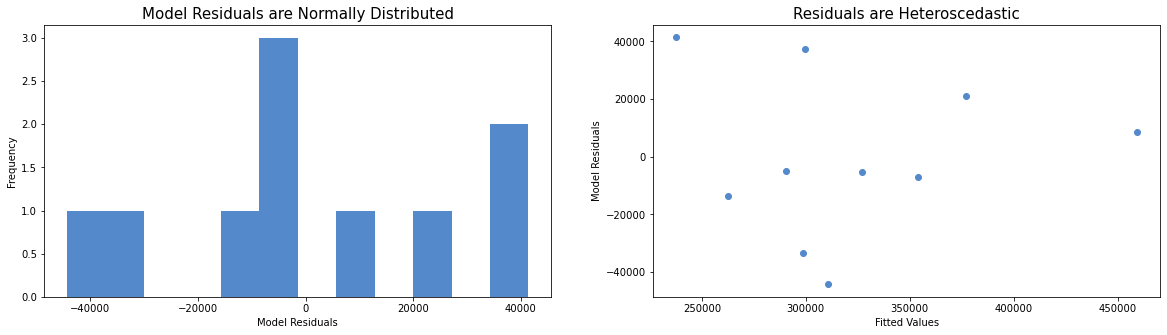

In [167]:
plt.figure()
plt.subplots(1,2, figsize = (20,5))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
plt.hist(model_resids, bins = 12, color = bakery.light_magpie)
plt.ylabel('Frequency')
plt.xlabel('Model Residuals')
plt.title('Model Residuals are Normally Distributed', fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values')
plt.ylabel('Model Residuals')
plt.title('Residuals are Heteroscedastic', fontsize=15)
plt.show()

**Observations**: 

# Summary

# Next Steps
- An ARIMA model will be developed for the monthly revenue to see if this improves the accuracy from the linear regression and baseline models 

>[Return to Contents](#Contents)